# Algoritmo MCMC implementando emcee

Ajuste usando minimos cuadrados
b,m = [ 32.00396939   2.191028  ]



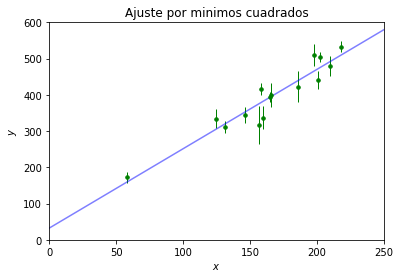

In [47]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline 
import corner

# Datos que ajustaremos
#  x, y, sigma_y
datos = np.array([[201,592,61],[244,401,25],[47,583,38],[287,402,15],[203,495,21],
                  [58,173,15],[210,479,27],[202,504,14],[198,510,30],[158,416,16],
                  [165,393,14],[201,442,25],[157,317,52],[131,311,16],[166,400,34],
                  [160,337,31],[186,423,42],[125,334,26],[218,533,16],[146,344,22]])

# Limites de las graficas
xlimits = [0,250]
ylimits = [0,600]
title_prefix = 'Problem set 1'
plot_format = '.png'

def get_data():
    # Obtener datos de x, y, sigma_y que agrupamos en datos
    x = datos[5:,0]
    y = datos[5:,1]
    sigmay = datos[5:,2]
    return (x, y, sigmay)

# Funcion para graficar las barras de error de los datos
def plot_yerr(x, y, sigmay):
    plt.errorbar(x, y, yerr=sigmay, fmt='.', ms=7, lw=1, color='g')
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.xlim(*xlimits)
    plt.ylim(*ylimits)
    plt.title(title_prefix)

# Modelo lineal   y = mx + b.
def modelo(x,m,b):
    y = m*x + b
    return y

def plot_line(b, m, **kwargs):
    x = np.array(xlimits)
    y = m*x + b
    p = plt.plot(x, y, 'b-', alpha=0.5, **kwargs)
    plt.xlim(*xlimits)
    plt.ylim(*ylimits)
    return p


# Método de minimos cuadrados, regresa los mejores valores (m, b)
def leastsq(x, y):
    print 'Ajuste usando minimos cuadrados'
    # numero depuntos
    N = len(x)
    # construyendo matriz
    X = np.zeros((N,2))
    X[:,0] = 1.
    X[:,1] = x
    #print 'X shape:', X.shape
    XTX = np.dot(X.T, X)
    #print 'XTX shape:', XTX.shape
    XTy = np.dot(X.T, y)
    #print 'XTy shape:', XTy.shape
    beta = np.dot(np.linalg.inv(XTX), XTy)
    print 'b,m =', beta
    (m, b) = beta
    print
    return (m, b)

# A continuacion se presentan un primer analisis de los datos

(x, y, sigmay) = get_data() 

# Graficar los puntos 
plot_yerr(x, y, sigmay)

# Solucion de m y b con minimos cuadrados ignorando el error de y.
(m, b) = leastsq(x, y)
plot_line(m, b)
plt.title('Ajuste por minimos cuadrados')
plt.show()


## MCMC usando librerias emcee y corner

Mejor m:  2.23253646578  Mejor b:  34.845896708


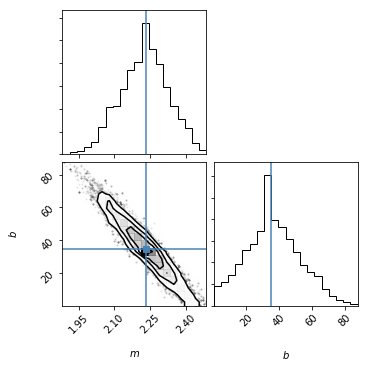

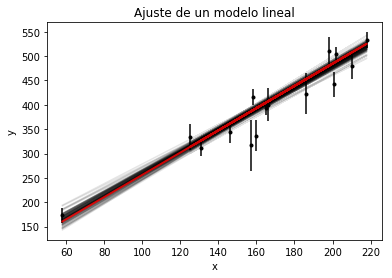

In [57]:
import scipy.optimize as op
import emcee
import corner


# Definimos la funcion loglikehood
def lnlikehood(theta,x,y,sigmay):
    y_d = y - modelo(x,theta[0],theta[1])
    lk = (y_d)**2/sigmay**2
    lk = -0.5*np.sum(lk)
    return lk 

# Definimos el prior
def lnprior(m,b):
    if ((1 < m <2.5) and (0 < b < 90)):
        return 0.0
    else:
        return -np.infty
    return 

def lnprob(mus,x,y,sigmay):
    lp = lnprior(mus[0],mus[1])
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlikehood(mus,x,y,sigmay)


# Valores iniciales para m y b, son valores propuestos
m = 2.1
b = 20 
mus = [m,b]

# Tamaño de los pasos (sigmas)
step_m = 0.1
step_b = 1.
sigmas = [step_m,step_b]

nll = lambda *args: -lnlikehood(*args)
result = op.minimize(nll, mus, args = (x,y,sigmay))
m_ml, b_ml = result["x"]
print 'Mejor m: ',m_ml,' Mejor b: ',b_ml
ndim, nwalkers = 2, 10

pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, sigmay))
sampler.run_mcmc(pos, 1000)
samples = sampler.chain[:,:].reshape((-1, ndim))
fig = corner.corner(samples, labels=["$m$", "$b$"],
                      truths=[m_ml, b_ml])
#fig.savefig("triangle.png")

#Ploteando la linea con los mejores valores
plt.figure()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Ajuste de un modelo lineal')
plt.legend()

xl = np.array([0, 10])
for m, b in samples[np.random.randint(len(samples), size=100)]:
    plt.plot(x, m*x+b, color="k", alpha=0.1)
plt.plot(x, m_ini*x+b_ini, color="r", lw=2, alpha=0.8)
plt.errorbar(x, y, yerr=sigmay, fmt=".k")

plt.show()    

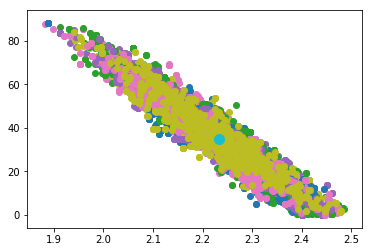

In [62]:
for i in range(nwalkers):
    plt.scatter(sampler.chain[i,:,0], sampler.chain[i,:,1])
    plt.scatter(sampler.chain[i,0,0], sampler.chain[i,0,1], s=100)

# Muestreo para todos los caminadores

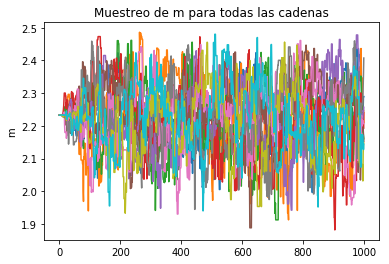

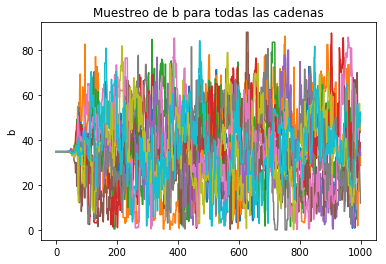

In [68]:
for i in range(nwalkers):
    plt.plot(sampler.chain[i,:,0])
plt.ylabel('m')
plt.title('Muestreo de m para todas las cadenas')
plt.show()

for i in range(nwalkers):
    plt.plot(sampler.chain[i,:,1])
plt.ylabel('b')
plt.title('Muestreo de b para todas las cadenas')
plt.show()